In [6]:
import matplotlib
import matplotlib.pyplot as plt
import h5py
import numpy as np
import phenom

In [7]:
matplotlib.rcParams.update({'font.size': 16})

In [3]:
def compute_integral(times, x, npts=None):
    """
    times = array of independent variable
    x = array of dependent variable
    npts = None (default to len(times)) number o fpoints to resample to integrate
    """
    
    if npts is None:
        npts = len(times)*2

    ix = IUS(times,  x)

    t1 = times[0]
    t2 = times[-1]
    res = []
    dt = times[1] - times[0]
    tss = np.linspace(t1+dt, t2, 1000)
    for ts in tss: 
        res.append(scipy.integrate.quad(ix, t1, ts)[0])
    res = np.array(res)

    ires = IUS(tss, res)
    return ires(times)

In [4]:
def match(h1, h2, times):
        
    dt = times[1] - times[0]
    n = len(times)
    df = 1.0/(n*dt)
    norm = 4. * df
    
    h1_fft = np.fft.fft(h1)
    h2_fft = np.fft.fft(h2)
    
    h1h1_sq = np.vdot(h1_fft, h1_fft) * norm
    h2h2_sq = np.vdot(h2_fft, h2_fft) * norm
    
    h1h1 = dt * np.sqrt(h1h1_sq)
    h2h2 = dt * np.sqrt(h2h2_sq)
    

    ifft = np.fft.ifft(np.conj(h1_fft) * h2_fft)
    
    return ifft / h1h1 / h2h2 * 4 * dt

In [5]:
def planck_taper(times, t1, t2):
    """times: array of times
    t1. for t<=t1 then return 0
    t2. for t>=t2 then return 1
    else return 1./(np.exp((t2-t1)/(t-t1)+(t2-t1)/(t-t2))+1)"""
    tout = []
    for t in times:
        if t<=t1:
            tout.append(0.)
        elif t>=t2:
            tout.append(1.)
        else:
            tout.append(1./(np.exp((t2-t1)/(t-t1)+(t2-t1)/(t-t2))+1))
    return np.array(tout)

In [6]:
# Newton gravity constant
# lal.G_SI: 6.67384e-11
G_Newt = 6.67384e-11

In [7]:
# light speed
# lal.C_SI: 299792458.0
c_ls = 299792458.0

In [8]:
# lal.MSUN_SI: 1.9885469549614615e+30
MSUN_SI = 1.9885469549614615e+30

In [9]:
MTSUN_SI = 4.925491025543576e-06

In [10]:
# lal.MRSUN_SI: 1476.6250614046494
MRSUN_SI = 1476.6250614046494

In [11]:
# lal.PC_SI: 3.085677581491367e+16
PC_SI = 3.085677581491367e+16

In [12]:
# lal.GAMMA: 0.5772156649015329
GAMMA = 0.5772156649015329

In [13]:
def Msun_to_sec(M):
    """
    convert mass (in units of solar masses)
    into seconds
    """
#     return M *lal.MSUN_SI* G_Newt / c_ls**3.
    return M * MTSUN_SI

In [14]:
def td_amp_scale(mtot, distance):
    """
    mtot in solar masses
    distance in Mpc
    M*G/c^2 * M_sun / dist
    """
    return mtot * MRSUN_SI / (distance * 1e6*PC_SI)

# functions

## PN

In [15]:
def TaylorT3_Omega_new(t, tc, eta, M):
    """
    22 mode angular GW frequency
    equation 7 in 0901.2437
    
    3.5PN term from https://arxiv.org/pdf/gr-qc/0610122.pdf and https://arxiv.org/pdf/0907.0700.pdf
    and this too apparently https://arxiv.org/pdf/gr-qc/0406012.pdf?
    
    https://git.ligo.org/lscsoft/lalsuite/blob/master/lalsimulation/src/LALSimInspiralTaylorT3.c
    
    https://git.ligo.org/lscsoft/lalsuite/blob/master/lalsimulation/src/LALSimInspiralPNCoefficients.c
    
    t: time
    tc: coalescence time
    eta: symmetric mass ratio
    M: total mass (Msun)
    """
    
    Msec = Msun_to_sec(M)
    Msec = M
    
    pi2 = np.pi*np.pi
    
    c1 = eta/(5.*Msec)
    
    td = c1 * (tc - t)
    
#     td = np.sqrt(td**2 + 1)
    
    theta = td**(-1./8.) # -1./8. = -0.125 
    
    theta2 = theta*theta
    theta3 = theta2*theta
    theta4 = theta3*theta
    theta5 = theta4*theta
    theta6 = theta5*theta
    theta7 = theta6*theta

    # pre factor
    ftaN = 1. / ( 8. * np.pi * Msec  )
    # 0PN
    fts1 = 1.
    # 0.5PN = 0 in GR
    # 1PN
    fta2 = 7.43/26.88 + 1.1/3.2 * eta
    # 1.5PN
    fta3 = -3./10. * np.pi
    # 2PN
    fta4 = 1.855099/14.450688 + 5.6975/25.8048 * eta + 3.71/20.48 * eta*eta
    # 2.5PN
    fta5 = (-7.729/21.504 + 1.3/25.6 * eta) * np.pi
    # 3PN
    fta6 = -7.20817631400877/2.88412611379200 + 5.3/20.0 * pi2 + 1.07/2.80 * GAMMA  \
           + (25.302017977/4.161798144 - 4.51/20.48 * pi2) * eta \
           - 3.0913/183.5008 * eta*eta + 2.35925/17.69472 * eta*eta*eta
            
    # 3.5PN
    fta7 = (-1.88516689/4.33520640 - 9.7765/25.8048 * eta + 1.41769/12.90240 * eta*eta) * np.pi

    # 3PN log term
    ftal6 = 1.07/2.80
    

    full = theta3*ftaN * (1. \
             + fta2*theta2 \
             + fta3*theta3 \
             + fta4*theta4 \
             + fta5*theta5 \
             + (fta6 + ftal6*np.log(2.*theta))*theta6 \
             + fta7*theta7)
    
    return full * 2 * np.pi # 2pi to go from freq to angular freq

In [16]:
def TaylorT3_phase(t, tc, eta, M, phi0=0, m=2):
    """
    orbital phase, but returns by default the m=2 mode
    equation 3.10a in https://arxiv.org/pdf/0907.0700.pdf
    
    https://git.ligo.org/lscsoft/lalsuite/blob/master/lalsimulation/src/LALSimInspiralTaylorT3.c
    
    https://git.ligo.org/lscsoft/lalsuite/blob/master/lalsimulation/src/LALSimInspiralPNCoefficients.c
    
    t: time
    tc: coalescence time
    eta: symmetric mass ratio
    M: total mass (Msun)
    phi0: reference orbital phase, default 0 
    m: m-mode default = 2
    """
    
    Msec = Msun_to_sec(M)
    Msec = M
    
    pi2 = np.pi*np.pi
    
    c1 = eta/(5.*Msec)
    
    td = c1 * (tc - t)
    
#     td = np.sqrt(td**2 + 1)
    
    theta = td**(-1./8.) # -1./8. = -0.125 
    
    theta2 = theta*theta
    theta3 = theta2*theta
    theta4 = theta3*theta
    theta5 = theta4*theta
    theta6 = theta5*theta
    theta7 = theta6*theta

    # pre factor
    ftaN = -1. / eta
    # 0PN
    fts1 = 1.
    # 0.5PN = 0 in GR
    # 1PN
    fta2 = 3.715/8.064 + 5.5/9.6 * eta
    # 1.5PN
    fta3 = -3./4. * np.pi
    # 2PN
    fta4 = 9.275495/14.450688 + 2.84875/2.58048 * eta + 1.855/2.048 * eta*eta
    # 2.5PN
    fta5 = (3.8645/2.1504 - 6.5/25.6 * eta) * np.pi
    # 3PN
    fta6 = 83.1032450749357/5.7682522275840 - 5.3/4.0 * np.pi*np.pi - 10.7/5.6 * GAMMA \
        + (-126.510089885/4.161798144 + 2.255/2.048 * np.pi*np.pi) * eta \
        + 1.54565/18.35008 * eta*eta - 1.179625/1.769472 * eta*eta*eta

            
    # 3.5PN
    fta7 = (1.88516689/1.73408256 + 4.88825/5.16096 * eta - 1.41769/5.16096 * eta*eta) * np.pi

    # 3PN log term
    ftal6 = -10.7/5.6
    
    # 2.5 PN log term
    ftal5 = np.log(theta)
    

    full = ftaN/theta5 * (1. \
             + fta2*theta2 \
             + fta3*theta3 \
             + fta4*theta4 \
             + (fta5*ftal5)*theta5 \
             + (fta6 + ftal6*np.log(2.*theta))*theta6 \
             + fta7*theta7)
    
    return m*(phi0 + full)

In [17]:
def Hhat22_x(x, eta):
    """
    https://arxiv.org/pdf/0802.1249.pdf - eq. 9.4a
    
    here we leave the expression to depend on the post-newtonian
    parameter 'x' so that you can choose how to calculate it.
    e.g., from PN like TaylorT3 or from the model which
    is TaylorT3 + corrections
    """
    
    xarr = np.zeros(6, dtype=np.complex128)
    
    C = 0.577216 # is the Euler constant

    xarr[0] = 1.
    xarr[1] = -107./42 + 55*eta/42
    xarr[2] = 2.*np.pi
    xarr[3] = -2173./1512 - 1069.*eta/216 + 2047.*eta**2/1512
    xarr[4] = (-107*np.pi/21 - 24.*1.j*eta + 34.*np.pi*eta/21) # there is an i... not sure what to do...
    
    x5a = 27027409./646800 - 856.*C/105 + 428*1.j*np.pi/105 + 2.*np.pi**2/3
    x5b = (-278185./33264 + 41*np.pi**2/96)*eta - 20261.*eta**2/2772 + 114635.*eta**3/99792
    
    x5log =  - 428.*np.log(16*x)/105
    
    xarr[5] = (x5a) + x5b # there is an i...  not sure what to do...
    
    pre = np.sqrt(16.*np.pi/5) * 2 * eta
    
    pn = xarr[0] + x*xarr[1] + x**(3/2.)*xarr[2] + x**2*xarr[3] + x**(5/2.)*xarr[4] + x**3*(xarr[5] + x5log)
    
    return pre * pn * x

In [18]:
def Hhat22_T3(t, t0, eta, M):
    """
    https://arxiv.org/pdf/0802.1249.pdf - eq. 9.4a
    Post-Newtonian expression for (l,m)=(2,2) time domain
    amplitude assuming TaylorT3 frequency evolution
    """

#     params_freq_ins={}
#     for k in PSF_freq_ins.vary_parnames:
#         params_freq_ins.update({k : PSF_freq_ins.model_evaluate(k, eta)})
#     GW22AngFreq = ff1.FreqFit.ins.ansatz(params_freq_ins, t, eta)
    
    GW22AngFreq = TaylorT3_Omega_new(t, t0, eta, M)
    OrgAngFreq = GW22AngFreq/2
    
    x = (M*OrgAngFreq)**(2./3)
    
    return Hhat22_x(x, eta)

# mk1

In [19]:
def analytic_phase_ins_ansatz(t, eta, tc, b, c, M=1, phi0=0, m=2):
    tau = eta * (tc - t) / (5*M)
#     return TaylorT3_phase(t, tc, eta, M=M, phi0=phi0, m=m) - 8*b*tau**(-1./8.) - 4*c*tau**(-1./4.)
#     return TaylorT3_phase(t, tc, eta, M=M, phi0=phi0, m=m) + 8*b*tau**(-1./8.) + 4*c*tau**(-1./4.)

#     t1=40*5**(1/8)*b*(tc-t) / (eta*(tc-t)/M)**(9/8)
    
    t1=40*b*M / eta / tau**(1/8)
    
#     t2=20*5**(1/4)*c*(tc-t) / (eta*(tc-t)/M)**(5/4)
    t2=20*c*M / eta / tau**(1/4)

    phase = TaylorT3_phase(t, tc, eta, M=M, phi0=phi0, m=m) + t1 + t2
    
#     return phase - phase[0]
    return phase

In [20]:
def analytic_phase_int_ansatz(t, tp, tdamp, lor_amp, a0, a1):
    
    """
    because my times are negative and I have a log I have to evaluate the
    term inside the log with -(t-tp) instead of (t-tp)
    """

#     phase = a0 * np.log(-(t-tp)) + a1*t + lor_amp*np.arctan((t-tp)/tdamp)
    phase = a0 * np.log(np.abs(t-tp)) + a1*t + lor_amp*np.arctan((t-tp)/tdamp)
#     return phase - phase[0]
    return phase

In [21]:
from scipy.special import hyp2f1

from mpmath import mp
from mpmath import hyp2f1 as mphyp2f1
from mpmath import tanh as mptanh
mp.dps=64
def analytic_phase_mrd_ansatz(t, t0, b, om_f, offset=0.175, kappa=0.44):
    """
    the hyp2f1 function will produce an inf if the 'z' argument (4th arg) is >= 1.
    This can happen due to finite precision errors in there term (0.5*(1+mptanh((tt-t0)/b))
    as tt >> t0
    To fix this I used a stupid number of dps in sympy mpmath.
    But should do a clever truncate and attact a constant slope instead.
    """
    try:
        kappa = kappa.value
    except:
        pass
    hyper = np.array([mphyp2f1(1, kappa, 1+kappa, 0.5*(1+mptanh((tt-t0)/b))) for tt in t])
    term1 = np.array([mptanh((tt-t0)/b) for tt in t])
    phase = offset * t + (1/kappa) * 2**(-1-kappa) * b * (om_f - offset) * hyper * (1 + term1)**kappa
    
#     hyper = hyp2f1(1, kappa, 1+kappa, 0.5*(1+np.tanh((t-t0)/b)))
#     term1 = 0.5*(1+np.tanh((t-t0)/b))
#     hyper = hyp2f1(1, kappa, 1+kappa, term1)
#     phase = offset * t + (1/kappa) * 2**(-1-kappa) * b * (om_f - offset) * hyper * (1 + np.tanh((t-t0)/b))**kappa
    
#     return phase - phase[0], hyper, term1
#     return phase - phase[0]
    return phase

In [22]:
def freq_ins_ansatz(t, eta, params):
    """
    this is the frequency inspiral ansatz.
    I needed an separate function so that I could use it in the amplitude inspiral model
    """
    
    tc = params['tc']
    b = params['b']
    c = params['c']
    M = 1
    
    tau = eta * (tc - t) / (5*M)
    model = (TaylorT3_Omega_new(t, tc, eta, M) + b*tau**(-9./8.) + c*tau**(-10./8.))
    
    return model

        
def freq_int_ansatz(t, params):

    tdamp = params['tdamp']
    tp = params['tp']
    lor_amp = params['lor_amp']
    a0 = params['a0']
    a1 = params['a1']
    
    model = (lor_amp * tdamp) / ( (t-tp)**2 + tdamp**2 ) + a0 / (t-tp) + a1

    return model

def freq_mrd_ansatz(t, params):

    t0 = params['t0']
    kappa = params['kappa']
    b = params['b']
    om_f = params['om_f']
    offset = params['offset']

    dt = t - t0
    num = 1. + np.tanh((dt/b))
    den = 2.

    model = offset + (om_f - offset) * ((num/den)**(kappa))

    return model

In [23]:
def amp_ins_ansatz(t, eta, params):

    tc = params['tc']

    a0 = params['a0']
    a1 = params['a1']

    tau = (tc-t)

    params_freq_ins = {
        'tc':params['tc'],
        'b':params['b'],
        'c':params['c']
    }

    GW22AngFreq = freq_ins_ansatz(t, eta, params_freq_ins)
    OrgAngFreq = GW22AngFreq / 2.

    M = 1
    x = (M*OrgAngFreq)**(2./3)

    T3amp = np.abs( Hhat22_x(x, eta) )

    model = T3amp + a0*tau**(-9./8.) + a1*tau**(-10./8.)

    return model
    
def amp_int_ansatz(t, params):

    tdamp = params['tdamp']
    tp = params['tp']
    lor_amp = params['lor_amp']
    a0 = params['a0']
    a1 = params['a1']
    
    model = (lor_amp * tdamp) / ( (t-tp)**2 + tdamp**2 ) + a0 / (t - tp) + a1

    return model

def amp_mrd_ansatz(t, params):

    A0 = params['A0']
    a1 = params['a1']
    a2 = params['a2']
    a3 = params['a3']
    b = params['b']

    kappa = params['kappa']
    t0 = params['t0']

    fhat = ((1 + np.tanh( (t-t0)/b ))/2)**kappa

    den = 1. + (a1 * ( fhat**2 - fhat**4 ))
    den += a2 * (fhat**4 - fhat**6)
    den += a3 * (fhat**6 - fhat**8)


    tanh_ab = np.tanh((t-t0)/b)
    tanh_ab_over_2_p_05 = tanh_ab/2 + 0.5

    fhatdot =  kappa*(1 - tanh_ab**2)*(tanh_ab_over_2_p_05)**kappa/(2*b*(tanh_ab_over_2_p_05))

    # normalise so that A0 is peak amp
    den /= np.max(den)
    fhatdot /= np.max(fhatdot)
    
    model = A0*fhatdot * den

    return np.sqrt(model)

In [24]:
def PSF_ansatz(params, eta):

    eta2 = eta*eta
    eta3 = eta2*eta
    eta4 = eta3*eta
    
    a = params['a']
    b = params['b']
    c = params['c']
    d = params['d']
    e = params['e']

    model = a + b*eta + c*eta2 + d*eta3 + e*eta4
    return model

def PSF_freq_ins(name, eta):
    if name == 'tc':
        params = dict(a=470.597717, b=-5211.88496, c=27529.8452, d=-69999.9986, e=65736.7732)
        value = PSF_ansatz(params, eta)
    elif name == 'b':
        params = dict(a=-0.03290704, b=-3.63518207, c=27.5751235, d=-82.2823976, e=89.9564049)
        value = PSF_ansatz(params, eta)
    elif name == 'c':
        params = dict(a=0.50445336, b=8.38150584, c=-64.9118203, d=205.626413, e=-244.753155)
        value = PSF_ansatz(params, eta)
        
    return value

def PSF_freq_int(name, eta):
    if name == 'tdamp':
        params = dict(a=74.9257490, b=121.163911, c=-2304.73380, d=11707.1868, e=-19425.1658)
        value = PSF_ansatz(params, eta)
    elif name == 'tp':
        params = dict(a=41.4577189, b=50.9110867, c=-1072.31292, d=4619.15831, e=-6824.93772)
        value = PSF_ansatz(params, eta)
    elif name == 'lor_amp':
        params = dict(a=-8.68954175, b=-131.704263, c=1397.26505, d=-5633.73808, e=8096.02270)
        value = PSF_ansatz(params, eta)
    elif name == 'a0':
        params = dict(a=-10.9733699, b=-108.883606, c=1035.63718, d=-4081.64431, e=5831.75177)
        value = PSF_ansatz(params, eta)
    elif name == 'a1':
        params = dict(a=0.09206339, b=-0.67906359, c=4.49944842, d=-15.2687804, e=20.0192924)
        value = PSF_ansatz(params, eta)
        
    return value

def PSF_freq_mrd(name, eta):
    if name == 't0':
        params = dict(a=7.67140690, b=-2.76322419, c=22.3188512, d=-230.782467, e=921.244695)
        value = PSF_ansatz(params, eta)        
    return value


def PSF_amp_ins(name, eta):
    if name == 'a0':
        params = dict(a=-34.6815964, b=846.370858, c=-8325.94229, d=34543.5326, e=-51438.2610)
        value = PSF_ansatz(params, eta)
    elif name == 'a1':
        params = dict(a=62.9956269, b=-1431.56072, c=12988.8856, d=-50271.4802, e=69999.9999)
        value = PSF_ansatz(params, eta)
        
    return value

def PSF_amp_int(name, eta):
    if name == 'tp':
        params = dict(a=54.7975453, b=-441.295715, c=3029.19697, d=-8677.58586, e=8569.67996)
        value = PSF_ansatz(params, eta)
    elif name == 'lor_amp':
        params = dict(a=0.33612583, b=-19.3781791, c=539.583918, d=-2765.56602, e=4623.06556)
        value = PSF_ansatz(params, eta)
    elif name == 'a0':
        params = dict(a=0.06625443, b=-41.1738150, c=300.284121, d=-1897.24393, e=3389.82409)
        value = PSF_ansatz(params, eta)
    elif name == 'a1':
        params = dict(a=0.00194817, b=0.71936078, c=-0.59881835, d=-0.06359352, e=1.86346496)
        value = PSF_ansatz(params, eta)
        
    return value

def PSF_amp_mrd(name, eta):
    if name == 'A0':
        params = dict(a=-0.00138219, b=0.06491347, c=1.12604662, d=5.95713833, e=-4.29388452)
        value = PSF_ansatz(params, eta)
    elif name == 'a1':
        params = dict(a=0.49149237, b=103.251125, c=-985.061966, d=3453.94730, e=-4333.54645)
        value = PSF_ansatz(params, eta)
    elif name == 'a2':
        params = dict(a=-7.22437951, b=-160.431492, c=1495.94693, d=-4559.95355, e=4605.42252)
        value = PSF_ansatz(params, eta)
    elif name == 'a3':
        params = dict(a=8.34567037, b=169.639675, c=-1361.28273, d=3389.61604, e=-2116.38087)
        value = PSF_ansatz(params, eta)
    elif name == 't0':
        params = dict(a=12.9241996, b=-11.2251343, c=134.809648, d=-1152.57936, e=2624.80008)
        value = PSF_ansatz(params, eta)
    elif name == 'kappa':
        params = dict(a=0.05366764, b=0.45798360, c=-5.06312311, d=27.2090801, e=-48.2909123)
        value = PSF_ansatz(params, eta)
        
    return value

In [25]:
print(PSF_freq_ins('tc',0.25))
print(PSF_freq_ins('b',0.25))
print(PSF_freq_ins('c',0.25))

51.27609418749978
-0.15252759460937493
0.7996867426562502


In [26]:
class Mk1(object):
    def __init__(self, times, q):
        """
        times to evaluate the model at
        q : mass-ratio
        """
        
        self.times = times
        self.q = q
        self.eta = phenom.eta_from_q(self.q)
        
        self.fin_spin = phenom.remnant.FinalSpin0815(self.eta, 0, 0)
        self.fring = phenom.remnant.fring(self.eta, 0, 0, self.fin_spin)
        self.fdamp = phenom.remnant.fdamp(self.eta, 0, 0, self.fin_spin)
        
        
        # freq model
        # build dict for params. parameter space fit values and fixed values
        
        freq_inc_tc = PSF_freq_ins('tc',self.eta)
        freq_inc_b = PSF_freq_ins('b',self.eta)
        freq_inc_c = PSF_freq_ins('c',self.eta)
        
        self.params_freq_ins={}
        self.params_freq_ins.update({
            'tc':freq_inc_tc,
            'b':freq_inc_b,
            'c':freq_inc_c
        })
            
        self.params_freq_int={}
        self.params_freq_int.update({
            'tdamp':PSF_freq_int('tdamp',self.eta),
            'tp':PSF_freq_int('tp',self.eta),
            'lor_amp':PSF_freq_int('lor_amp',self.eta),
            'a0':PSF_freq_int('a0',self.eta),
            'a1':PSF_freq_int('a1',self.eta)
        })
            
        self.params_freq_mrd={}
        self.params_freq_mrd.update({
            't0':PSF_freq_mrd('t0', self.eta),
            'om_f' : self.fring*2.*np.pi,
            'b' : 1./self.fdamp/2./np.pi,
            'offset': 0.175,
            'kappa':0.44
        })
        
        # amp
        self.params_amp_ins={}
        self.params_amp_ins.update({
            'a0': PSF_amp_ins('a0', self.eta),
            'a1': PSF_amp_ins('a1', self.eta)
        })

        self.params_amp_ins.update({
            'tc':freq_inc_tc,
            'b':freq_inc_b,
            'c':freq_inc_c
        })
        
        self.params_amp_int={}
        self.params_amp_int.update({
            'tdamp' : 132.,
            'tp':PSF_amp_int('tp', self.eta),
            'lor_amp':PSF_amp_int('lor_amp', self.eta),
            'a0':PSF_amp_int('a0', self.eta),
            'a1':PSF_amp_int('a1', self.eta)
        })
        
        self.params_amp_mrd={}
        self.params_amp_mrd.update({
            'b' : 1./self.fdamp/2./np.pi,
            'A0':PSF_amp_mrd('A0', self.eta),
            'a1':PSF_amp_mrd('a1', self.eta),
            'a2':PSF_amp_mrd('a2', self.eta),
            'a3':PSF_amp_mrd('a3', self.eta),
            't0':PSF_amp_mrd('t0', self.eta),
            'kappa':PSF_amp_mrd('kappa', self.eta)
        })
        
        # full amp
        self.amp = self.amp_func(self.times, self.eta)
        
        # full freq
        self.freq = self.freq_func(self.times, self.eta)
        
        # full phase analytic
        self.phase = self.phase_func(self.times, self.eta)
        
        self.h = self.amp * np.exp(-1.j * self.phase)
        
    def amp_func(self, times, eta, t0_ins_int=-200, t0_int_mr=-40):
        
        mask_ins = times <= t0_ins_int
        mask_int = (times > t0_ins_int) & (times <= t0_int_mr)
        mask_mr = times > t0_int_mr
        
        amp_ins = amp_ins_ansatz(times[mask_ins], eta, self.params_amp_ins)
        amp_int = amp_int_ansatz(times[mask_int], self.params_amp_int)
        amp_mr = amp_mrd_ansatz(times[mask_mr], self.params_amp_mrd)
        
#         enforce some level on continuity
        a0 = amp_ins[-1] - amp_int[0]
        amp_int += a0
        
        amp_ins_int = np.concatenate((amp_ins, amp_int))
        
        a1 = amp_mr[0] - amp_ins_int[-1]
        amp_ins_int += a1

        imr_amp = np.concatenate((amp_ins_int, amp_mr))
#         imr_amp = np.concatenate((amp_ins, amp_int, amp_mr))

        return imr_amp
    
    def freq_func(self, times, eta, t0_ins_int = -500, t0_int_mr = -5):
        
        mask_ins = times <= t0_ins_int
        mask_int = (times > t0_ins_int) & (times <= t0_int_mr)
        mask_mr = times > t0_int_mr
        
        freq_ins = freq_ins_ansatz(times[mask_ins], eta, self.params_freq_ins)
        freq_int = freq_int_ansatz(times[mask_int], self.params_freq_int)
        freq_mr = freq_mrd_ansatz(times[mask_mr], self.params_freq_mrd)

        imr_freq = np.concatenate((freq_ins, freq_int, freq_mr))

        return imr_freq

    def phase_func(self, times, eta, t0_ins_int = -500, t0_int_mr = -5):
        
        # to get connection correct need to do this +dt
        # and then later not use all the int and the mrd phases
        dt = times[1] - times[0]
            
        mask_ins = times <= t0_ins_int+dt
        mask_int = (times > t0_ins_int) & (times <= t0_int_mr + dt)
        mask_mr = times > t0_int_mr
        
        phase_ins = analytic_phase_ins_ansatz(times[mask_ins], eta, **self.params_freq_ins)
        phase_int = analytic_phase_int_ansatz(times[mask_int], **self.params_freq_int)
        phase_mrd = analytic_phase_mrd_ansatz(times[mask_mr], **self.params_freq_mrd)
        
        # leave ins where it is and connect int and mrd by C(0)
        
        ins_int = phase_ins[-1] - phase_int[0]
        phase_int += ins_int
        
        ins_int_mrd = phase_int[-1] - phase_mrd[0]
        phase_mrd += ins_int_mrd
        
        analytic_imr_phase = np.concatenate((phase_ins[:-1], phase_int[:-1], phase_mrd))
        analytic_imr_phase -= analytic_imr_phase[0]

        return np.array(analytic_imr_phase, dtype=np.float64)
    

In [27]:
times = np.linspace(-1000, 60, 1000)
mk1 = Mk1(times, 1.1)

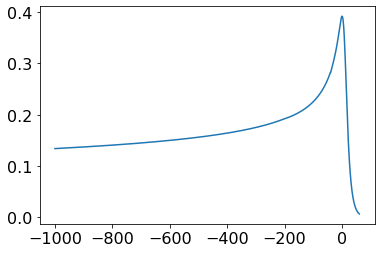

In [28]:
plt.figure()
plt.plot(times, mk1.amp)
# plt.yscale('log')

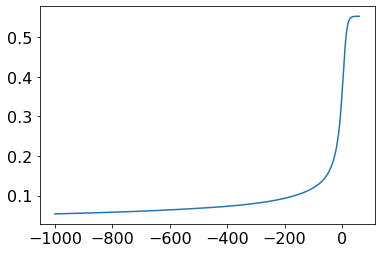

In [29]:
plt.figure()
plt.plot(times, mk1.freq)

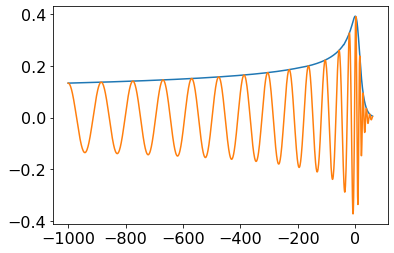

In [30]:
plt.figure()
plt.plot(times, mk1.amp)
plt.plot(times, np.real(mk1.h))

### test script

In [3]:
import Mk1 as Mk1script
import numpy as np

In [8]:
times = np.linspace(-1000, 60, 1000)
mk1 = Mk1script.Mk1(times, 1.1)

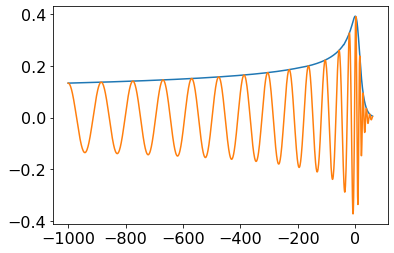

In [9]:
plt.figure()
plt.plot(times, mk1.amp)
plt.plot(times, np.real(mk1.h))